In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from urllib.parse import urlparse
from collections import Counter

In [12]:
np.random.seed(42)

# Clustering

This part of the project uses the cleaned dataset extracted in the previous notebook. With data cleaning out of the way, the next step for our analysis is clustering. In this section, we explore different clustering methods and parameters and do a evaluate the quality of results. Clustering will be done based on the number of time a speaker has been quoted by a publisher.

In [14]:
df = pd.read_csv("../data/clean_quotes.csv.bz2", usecols=["speaker", "journal"])

In [15]:
df.head()

,speaker,journal
0,Sue Myrick,thehill.com
1,President Donald Trump,thehill.com
2,President Donald Trump,thehill.com
3,Nancy Pelosi,thehill.com
4,Lisa Murkowski,thehill.com


We first count the number of occurences of a speaker for each publisher. Publishers with less than 10 quotes are removed: having very few quotes means there is not much information we can use to cluster them. This threshold is mostly arbitrary.

In [16]:
MIN_QUOTES = 10

df = df.groupby("journal").filter(lambda group: len(group.index) > MIN_QUOTES)
speakers_by_media = df.groupby("journal")
speakers_by_media_count = speakers_by_media.agg({"speaker": Counter})

print(f"Media entities with more than {MIN_QUOTES} quotes: {len(speakers_by_media)}")

Media entities with more than 10 quotes: 7474


We then create vectors from these counts

In [17]:
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(speakers_by_media_count["speaker"])

print(f"Vector size: {X.shape[1]}")

Vector size: 101649


In [60]:
# Some useful method we will use from this point
# There is no need to understand them fully to grasp the reasoning below

def kmeans(X, k):
    return KMeans(
            n_clusters=k,
            init="k-means++",
            max_iter=100,
            n_init=1,
    ).fit_predict(X)

def dbscan(X, eps):
    return DBSCAN(eps=eps).fit_predict(X)

def s_score(X, labels):
    return metrics.silhouette_score(X, labels, random_state=42, sample_size=1000)

def plot_clusters(X, labels_list, titles, rows, cols):
    assert len(labels_list) == len(titles)
    assert len(labels_list) <= rows * cols
    
    fig, axs = plt.subplots(rows, cols, figsize=(20, 6), sharey=True, sharex=True)
    for i, (labels, title) in enumerate(zip(labels_list, titles)):
        ax = axs[i // cols, i % cols]
        ax.scatter(X[:,0], X[:,1], c=labels, alpha=0.6)
        ax.set_title(title)

def clusters_top_elements(labels, values_and_weights, n_samples = 10):
    for label in sorted(set(labels[labels >= 0])):
        members = values_and_weights[labels == label]
        sample_size = min(len(members), n_samples)
        print(f"\nCluster {label} ({len(members)} elements)")
        print(members.nlargest(sample_size, columns=["speaker"]))

def dbscan_cluster_count(labels):
    return len(set(labels)) - (1 if -1 in labels else 0)
    

def dbscan_metrics(X, labels, media_names):
    n_clusters = dbscan_cluster_count(labels)
    n_noise = list(labels).count(-1)

    print(f"{n_clusters} clusters")
    print(f"Some noise: {n_noise / len(labels) * 100:0.1f}%" if n_noise else "No noise")
    print(s_score(X, labels))
    clusters_top_elements(labels, media_names)
        
    pd.Series(Counter(labels)).plot.bar(title="Cluster sizes", xlabel="Cluster index", ylabel="Publisher count")

Since the data is very high dimensional, we first apply dimensionality reduction. We use `TruncatedSVD`, which works with sparse data. Afterwards, we normalize the data. This combination is known as [latent semantic analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis), which is very useful to analyse relationships. We also produce a 2d version of the vectors using PCA for visualization purposes.

In [19]:
DIMS = 10

svd = TruncatedSVD(DIMS, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_intermediate = lsa.fit_transform(X)
X_final = PCA(n_components=2).fit_transform(X_intermediate)

## KMeans

We first try clustering using KMeans with a range of values for k. We observe the best silouhette score with k=3

In [20]:
k_list = range(2, 10)

kmeans_labels = [kmeans(X_intermediate, k) for k in k_list]
kmeans_titles = [f"k = {k}" for k in k_list]

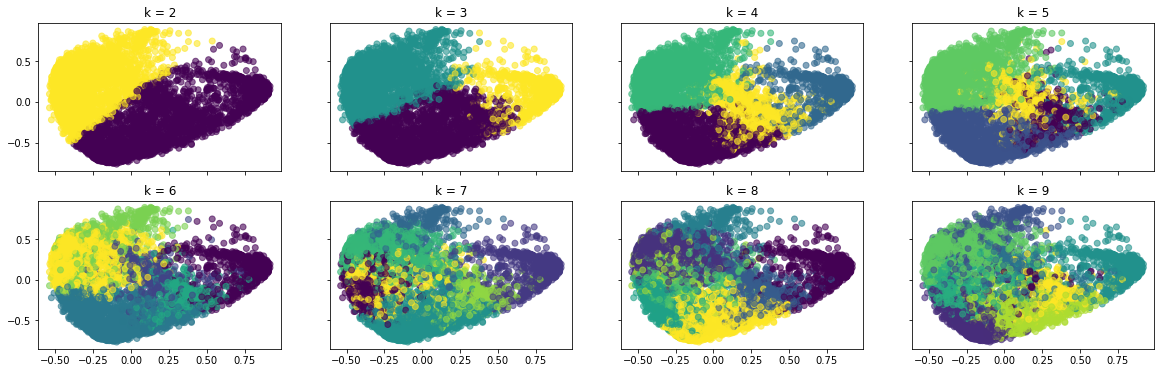

In [21]:
plot_clusters(X_final, kmeans_labels, kmeans_titles, 2, 4)

<AxesSubplot:title={'center':'Silhouette score'}, xlabel='k'>

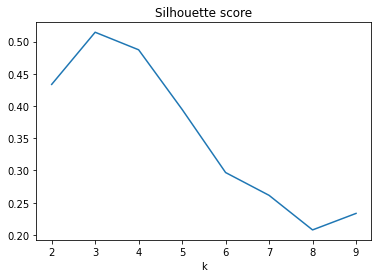

In [59]:
pd.Series(index=k_list, data=[s_score(X_final, labels) for labels in kmeans_labels]).plot(title="Silhouette score", xlabel="k")

Showing biggest publishers for each cluster when k=3 shows some interesting results: publishers appear to be grouped geographically. The distribution of publishers between clusters is more or less balanced.

2896
                          speaker
journal                          
www.nbcsports.com           34212
www.brisbanetimes.com.au    30806
www.smh.com.au              30733
www.theage.com.au           26945
www.canberratimes.com.au    23943
nationalfootballpost.com    20752
www.thechronicle.com.au     20059
www.news-mail.com.au        19460
www.qt.com.au               19145
www.gympietimes.com.au      19099
3328
                         speaker
journal                         
uspolitics.einnews.com    138845
msn.com                    72249
www.news965.com            71362
www.msn.com                66047
www.breitbart.com          62276
www.wokv.com               61934
www.washingtontimes.com    45154
www.wsbradio.com           43636
www.krmg.com               36945
www.nbcnews.com            34867
1250
                            speaker
journal                            
express.co.uk                 26479
www.mirror.co.uk              24695
www.bucksfreepress.co.uk      18750
w

<AxesSubplot:title={'center':'Cluster sizes'}, xlabel='Cluster index', ylabel='Publisher count'>

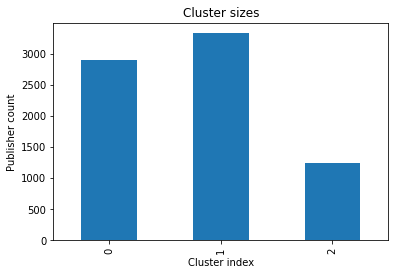

In [37]:
media_count = df.groupby("journal").count()
clusters_top_elements(kmeans_labels[1], media_count)
pd.Series(Counter(kmeans_labels[1])).plot.bar(title="Cluster sizes", xlabel="Cluster index", ylabel="Publisher count")

Although interesting, this clustering method might not be granular enough to really show more niche clusters.

## DBScan

We now try to use DBScan, adjusting `eps` parameter to get a sense of how it affects the results.

In [27]:
eps_list = np.linspace(0.05, 0.2, 8)

dbscan_labels = [dbscan(X_intermediate, eps) for eps in eps_list]
dbscan_titles = [f"eps = {eps:0.2f}" for eps in eps_list]

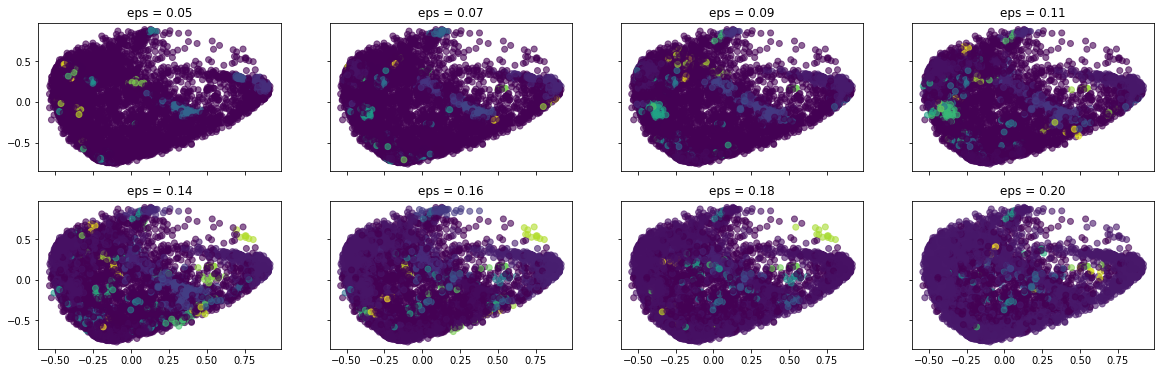

In [28]:
plot_clusters(X_final, dbscan_labels, dbscan_titles, 2, 4)

Not easily visualized, metrics to the rescue! We plot silouhette score and cluster count as a function of eps. The best value for eps seems to be 0.16.

<AxesSubplot:title={'center':'Cluster count'}, xlabel='eps'>

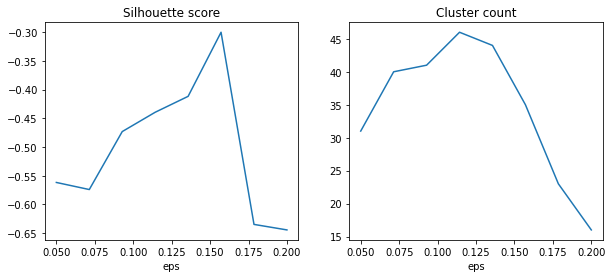

In [58]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharex=True)
pd.Series(index=eps_list, data=[s_score(X_final, labels) for labels in dbscan_labels]).plot(title="Silhouette score", xlabel="eps", ax=axes[0])
pd.Series(index=eps_list, data=[dbscan_cluster_count(labels) for labels in dbscan_labels]).plot(title="Cluster count", xlabel="eps", ax=axes[1])

Similarly, we examine the case where eps=0.16 in more details.

44 clusters
Some noise: 36.5%
-0.4117601394874572

Cluster 0 (720 elements)
                            speaker
journal                            
www.nbcsports.com             34212
nationalfootballpost.com      20752
www.cheatsheet.com            17117
www.cbssports.com             10182
www.eonline.com                7223
www.usmagazine.com             7106
nba.nbcsports.com              3566
swxrightnow.com                3110
arizonasports.com              2942
www.thehollywoodgossip.com     2863

Cluster 1 (1947 elements)
                         speaker
journal                         
www.msn.com                66047
www.breitbart.com          62276
www.wokv.com               61934
www.washingtontimes.com    45154
www.nbcnews.com            34867
newsok.com                 34273
wtmj.com                   32253
stamfordadvocate.com       30864
ctpost.com                 30830
newstimes.com              30072

Cluster 2 (953 elements)
                            speaker
journal

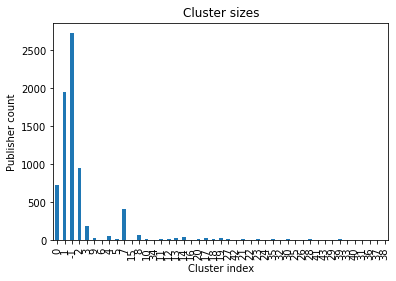

In [55]:
dbscan_metrics(X_final, dbscan_labels[4], media_count)

With DBScan, the distribution of publisher across clusters is a lot less uniform. However, a lot of clusters make sense. This way of creating clusters seems very promising.

## Conclusion

Applying DBScan on our clean version of quotebank yields good, multi facetted clusters that would be ripe for further analysis. KMeans in comparison seems to generalize much more. With a little bit more time, we would also like to try other clustering methods, like agglomerative clustering for example.